# Assignment 5: Web Scraping and Big Data

**NOTE: THIS ASSIGNMENT IS OPTIONAL**

You must complete one out of homeworks #4, #5, and #6.

**Due date: Thursday, 11/5 by the start of class**

The notebook should be submitted to your own private repository on GitHub, which can be created using the following link:

https://classroom.github.com/a/XayIoOpN

### Part 1: Scraping Craigslist

In this section, you will use BeautifulSoup to scraping data for hundreds of apartments from Philadelphia's Craigslist portal.

### Part 2: Exploring a "large" dataset of your choice

In this section, you'll use datashader to create an animated timelapse of a "large" dataset of your choice.

## Part 1: Scraping Craigslist

In this part, we'll be extracting information on apartments from Craigslist search results. You'll be using BeautifulSoup to extract the relevant information from the HTML text. 

For reference on CSS selectors, please see the [notes from Week 6](https://github.com/MUSA-550-Fall-2020/week-6/blob/master/css-selectors.md).

### Getting the HTML

First we need to figure out how to submit a query to Craigslist. As with many websites, one way you can do this is simply by constructing the proper URL and sending it to Craigslist. Here's a sample URL that is returned after manually typing in a search to Craigslist:

 http://philadelphia.craigslist.org/search/apa?bedrooms=1&pets_cat=1&pets_dog=1&is_furnished=1

There are two components to this URL:

1. The base URL: `http://philadelphia.craigslist.org/search/apa`
1. The user's search parameters: `?bedrooms=1&pets_cat=1&pets_dog=1&is_furnished=1`

We will use `requests.get()` function to get the search page's response. For the search parameters, we will set `bedrooms=1`, which will make sure the number of bedrooms is listed. 

This can be done easiest by using the `params` keyword of the `get()` function. We didn't cover this in the lecture, so I've went ahead and done the necessary steps.

In [1]:
import requests

In [2]:
url_base = 'http://philadelphia.craigslist.org/search/apa'
params = {'bedrooms': 1,
          'availabilityMode': 0,
          'minSqft': 500,
          'min_bedrooms': 1,
          'postal': 19107,
          'search_distance': 5}
resp = requests.get(url_base, params=params)

In [3]:
# Note that requests automatically created the right URL
print(resp.url)

https://philadelphia.craigslist.org/search/apa?bedrooms=1&availabilityMode=0&minSqft=500&min_bedrooms=1&postal=19107&search_distance=5


## 1.1 Parse the HTML

- Use BeautifulSoup to parse the HTML response.
- Use your browser's Web Inspector to identify the HTML element that holds the information on each apartment listing.
- Use BeautifulSoup to extract these elements from the HTML.

You should have a list of 120 elements, where each element is the listing for a specific apartment on the search page.

In [4]:
from bs4 import BeautifulSoup

In [5]:
soup = BeautifulSoup(resp.content, 'html.parser')

In [6]:
selector = '.result-info'
listings = soup.select(selector)

## 1.2 Find the relevant pieces of information

We will now focus on the first element in the list of 120 apartments. Use the `prettify()` function to print out the HTML for this first element. 

From this HTML, identify the HTML elements that hold:

- The apartment price
- The number of bedrooms and square footage (this will be in a single element)
- The apartment title
- The datetime string of the posting, e.g., '2019-03-23 12:07'

For the first apartment, print out each of these pieces of information, using BeautifulSoup to select the proper elements.

**Hint:** Each of these can be extracted using the `text` attribute of the selected element object, except for the datetime string. This information is stored as an *attribute* of an HTML element and is not part of the displayed text on the webpage.

In [7]:
print(listings[0].prettify())

<div class="result-info">
 <span class="icon icon-star" role="button">
  <span class="screen-reader-text">
   favorite this post
  </span>
 </span>
 <time class="result-date" datetime="2020-09-24 12:52" title="Thu 24 Sep 12:52:28 PM">
  Sep 24
 </time>
 <h3 class="result-heading">
  <a class="result-title hdrlnk" data-id="7184571397" href="https://philadelphia.craigslist.org/apa/d/philadelphia-welcome-home-to-this/7184571397.html" id="postid_7184571397">
   Welcome home to this gorgeous unit, right in the heart of Washing Squa
  </a>
 </h3>
 <span class="result-meta">
  <span class="result-price">
   $1,699
  </span>
  <span class="housing">
   1br -
                    5941ft
   <sup>
    2
   </sup>
   -
  </span>
  <span class="result-hood">
   (1203 Spruce St #2F)
  </span>
  <span class="result-tags">
   <span class="pictag">
    pic
   </span>
   <span class="maptag">
    0mi
   </span>
  </span>
  <span class="banish icon icon-trash" role="button">
   <span class="screen-reader-

In [8]:
print(listings[0].select_one('.result-price').text)
print(listings[0].select_one('.housing').text.replace(' ', '').replace('\n', ''))
print(listings[0].select_one('.result-title').text)
print(listings[0].select_one('.result-date').text)

$1,699
1br-5941ft2-
Welcome home to this gorgeous unit, right in the heart of Washing Squa
Sep 24


## 1.3 Functions to format the results 

In this section, you'll create two functions that take the price and time results from the last section and format them properly.

I've provided a function that will format the size and bedrooms string properly (no additional work needed), and started two functions to format the price and time. You should finish theses functions in this section.

In [21]:
import re
from datetime import datetime

In [22]:
def format_size_and_bedrooms(size_string):
    """
    Extract size and number of bedrooms from the raw
    text, using regular expressions
    """
    split = re.findall("\n(.*?) -", size_string)
    
    # both size and bedrooms are listed
    if len(split) == 2:
        n_brs = split[0].strip().replace('br', '')
        this_size = split[1].strip().replace('ft2', '')
    # only bedrooms is listed
    elif 'br' in split[0]:
        n_brs = split[0].strip().replace('br', '')
        this_size = np.nan
    # only size is listed
    elif 'ft2' in split[0]:
        # It's the size
        this_size = split[0].strip().replace('ft2', '')
        n_brs = np.nan
    
    # return floats
    return float(this_size), float(n_brs)

Not exactly the code that you hinted at, but this is a little tighter than `string.replace`, and the same result.

In [23]:
def format_price(price_string):
    # Format the price string and return a float
    # 
    # This will involve:
    # Using the string.replace() function to remove unwanted characters
    # and replacing them with the empty string ""
    return float(re.sub(r'\W+', '', price_string))

I was a little confused here about why this should be a *time* and not a *date*, because it seems like we are just trying to grab the listing time—which is just a day and month, so I simply reformatted that, rather than incorporating any hour, minute and second information. 

In [24]:
def format_time(date_string):
    # Return a Datetime object from the datetime string
    return datetime.strptime(f"{date_string} 2020", '%b %d %Y') 

## 1.4: Putting it all together

In this part, you'll complete the code block below using results from previous parts. The code will loop over 5 pages of search results and scrape data for 600 apartments.

In the code below, the outer for loop will loop over 5 pages of search results. The inner for loop will loop over the 120 apartments listed on each search page.

After filling in the missing pieces and executing the code cell, you should have a Data Frame called `results` that holds the data for 600 apartment listings.

#### Notes

Be careful if you try to scrape more listings. Craigslist will temporarily ban your IP address (for a very short time) if you scrape too much at once. I've added a `sleep()` function to the for loop to wait 30 seconds between scraping requests.

If the for loop gets stuck at the "Processing page X..." step for more than a minute or so, your IP address is probably banned temporarily, and you'll have to wait a few minutes before trying again.

In [25]:
import numpy as np
import pandas as pd

from time import sleep

In [26]:
results = []

# Search in batches of 120 for 5 pages
# NOTE: you will get temporarily banned if running more than ~5 pages or so
# the API limits are more leninient during off-peak times, and you can try
# experimenting with more pages
max_pages = 5
results_per_page = 120
search_indices = np.arange(0, max_pages*results_per_page, results_per_page) 
url = 'http://philadelphia.craigslist.org/search/apa'

# loop over each page of search results
for i, s in enumerate(search_indices):
    print('Processing page %s...' % (i+1) )
    
    # get the response
    resp = requests.get(url, params={'bedrooms': 1, 's': s})
    
    # YOUR CODE: get the list of all aparements
    # This is the same code from Part 1.1
    # It should be a list of 120 apartments
    path = '.result-info' 
    apts = soup.select(path)
    print("number of apartments = ", len(apts))

    # loop over each apartment in the list
    page_results = []
    for apt in apts:
        
        # YOUR CODE: the bedrooms/size string
        sizes_brs = apt.select_one('.housing').text

        # YOUR CODE: the title string
        title = apt.select_one('.result-title').text
        
        # YOUR CODE: the price string
        price = apt.select_one('.result-price').text

        # YOUR CODE: the time string
        dtime = apt.select_one('.result-date').text
        
        # format using functions from Part 1.3
        sizes, brs = format_size_and_bedrooms(sizes_brs)
        price = format_price(price)
        dtime = format_time(dtime)
        
        # save the result
        page_results.append([dtime, price, sizes, brs, title])
        

    # create a dataframe and save
    col_names = ['time', 'price', 'size', 'brs', 'title']
    df = pd.DataFrame(page_results, columns=col_names)
    results.append(df)
    
    print("sleeping for 30 seconds between calls")
    sleep(30)
    
# Finally, concatenate all the results
results = pd.concat(results, axis=0)

Processing page 1...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 2...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 3...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 4...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 5...
number of apartments =  120
sleeping for 30 seconds between calls


In [27]:
results.head()

,time,price,size,brs,title
0,2020-09-24,1699.0,5941.0,1.0,"Welcome home to this gorgeous unit, right in t..."
1,2020-09-24,2000.0,901.0,2.0,Located in the heart of Washington Square West
2,2020-09-24,1699.0,5941.0,1.0,"Welcome home to this gorgeous unit, right in t..."
3,2020-09-28,1000.0,600.0,1.0,1 bed 1 bath for rent
4,2020-09-28,850.0,700.0,1.0,1 bed 1 bath for rent


## 1.5 Plotting the distribution of prices

Use matplotlib's `hist()` function to make two histograms for:

- Apartment prices
- Apartment prices per square foot (price / size)

Make sure to add labels to the respective axes and a title describing the plot.

### Side note: rental prices per sq. ft. from Craigslist

The histogram of price per sq ft should be centered around ~1.5. Here is a plot of how Philadelphia's rents compare to the other most populous cities:

<img src="imgs/rental_prices_psf.png" width=600/>

[Source](https://arxiv.org/pdf/1605.05397.pdf)

In [28]:
import matplotlib.pyplot as plt

My data skew a little more expensive than the data from Philadelphia as a whole because, to practice using the `get` request, I added a search radius around Center City. 

Text(0.5, 1.0, '$ / sf')

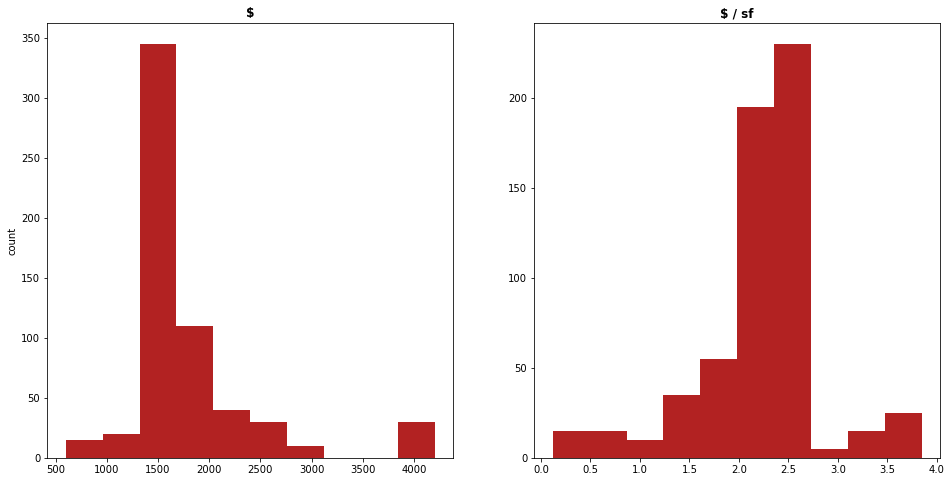

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].hist(results['price'], color='firebrick')
axs[0].set_title('$', weight='bold')
axs[0].set_ylabel('count')

axs[1].hist(results['price'] / results['size'], color='firebrick')
axs[1].set_title('$ / sf', weight='bold')

## 1.6 Comparing prices for different sizes 

Use `altair` to explore the relationship between price, size, and number of bedrooms. Make an interactive scatter plot of price (x-axis) vs. size (y-axis), with the points colored by the number of bedrooms. 

Make sure the plot is interactive (zoom-able and pan-able) and add a tooltip with all of the columns in our scraped data frame.

With this sort of plot, you can quickly see the outlier apartments in terms of size and price.

In [37]:
import altair as alt

In [41]:
colormap = alt.Scale(
    domain=[1, 2, 3, 4],
    range=[
        "cornflowerblue",
        "mediumseagreen",
        "darkorange",
        "firebrick",
    ],
)

selection = alt.selection_multi(fields=['brs'], bind='legend')

full = alt.Chart(results).mark_circle(size=60).encode(
    x=alt.X("price"),
    y=alt.Y("size"),
    color=alt.Color("brs:O", scale=colormap),
    tooltip=['title', 'price', 'size', 'brs', 'time']
).interactive()

full

alt.Chart(...)

## Part 2: Making an animated map with Datashader

In this part, you will load a "large" data set of your choice and make an animated map of the data using datashader. 

There are several good options available from Open Data Philly, but you are welcome to choose a different source, as long it meets the requirements below.

#### Deliverable
Your final result should be a GIF animating changes in the data set in time. This GIF should be submitted to your repository, and the code used to produce the GIF should be in the notebook.

#### Notes
- For best results with datashader, the dataset should be at least 500,000 rows in size. If you are having difficulty finding a data set large enough, please email me.
- The data must have a date time column, so that you can animate the data in time.
- You can use either dask or pandas to load the data. If you're data set is approaching the size of your machine's memory, you will want to use dask.
- Recommendations from Open Data Philly include: 
    - [311 Requests](https://www.opendataphilly.org/dataset/311-service-and-information-requests)
    - [Crime Incidents](https://www.opendataphilly.org/dataset/crime-incidents)
    - [L&I Code Violations](https://www.opendataphilly.org/dataset/licenses-and-inspections-violations)
    - [Real Estate Transfers](https://www.opendataphilly.org/dataset/real-estate-transfers)
- You can animate the data by the hour or by the year, e.g., parking violations by hour of day, or parking violations by year.

#### Examples
I've includes several potential examples in the assignment repository.

#### Optional
You can overlay Philadelphia city limits using geopandas. See the lecture slides for an example of how to do this.

In [47]:
from google.cloud import bigquery

bqclient = bigquery.Client.from_service_account_json("musa-509-75492c1cf2ae.json")

You should use these credentials to replicate.

In [42]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import datashader as ds
import numpy as np

import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

from datashader.bundling import connect_edges, hammer_bundle
from datashader.colors import inferno, viridis
from datashader.utils import export_image
from datashader.utils import lnglat_to_meters

from colorcet import palette
from matplotlib import cm

import cenpy
import imageio

acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 1-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census Current (2018) WMS

I define two functions here, one to grab Tiger files for Census Block Groups and another to pull data from a cloud storage account (mine, so try not run too many queries) that contains origin and destination FIPS codes for those block groups.  

In [43]:
def get_nodes(fips):
    
    #split up the fips codes
    state = fips[:2]
    county = fips[2:]
    
    #build the query
    where_clause = f"STATE = {state} AND COUNTY = {county}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    #latlon to meters
    block_groups = block_groups.to_crs(3857)
    
    #extract X and Y
    nodes = pd.DataFrame({'X': block_groups.centroid.x,
                          'Y': block_groups.centroid.y,
                          'geometry': block_groups.geometry,
                          'cbg': block_groups.GEOID.astype('int64')}).set_index('cbg')
    
    # return results
    return nodes

def get_edges(fips, month, cbgs):

    print(month)
    
    # build the query
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("fips", "STRING", fips),
            bigquery.ScalarQueryParameter("month", "STRING", month),
        ]
    )
    
    query = f"""
        SELECT poi_cbg, home_cbg, sum(visits) as visits
        FROM (SELECT 
                lpad(CAST(poi_cbg AS STRING), 12, '0') as poi_cbg, 
                REGEXP_EXTRACT(unnested, '(.*?):') as home_cbg, 
                CAST(REGEXP_EXTRACT(unnested, ':(.*)') AS NUMERIC) as visits
              FROM `tidal-digit-291220.safegraph.2020_{month}`
              CROSS JOIN UNNEST(SPLIT(regexp_replace(REPLACE(REPLACE(visitor_home_cbgs, '{{', ''), '}}', ''), '\\"', ''))) as unnested
              WHERE SUBSTR(lpad(CAST(poi_cbg AS STRING), 12, '0'), 0, 5) IN {fips} AND visitor_home_cbgs != '{{}}')
        GROUP BY poi_cbg, home_cbg
            """
    
    # execute it
    resp = bqclient.query(query, job_config=job_config)
    data = resp.to_dataframe()
    
    # create a dataframe
    edges = data.rename(columns={'poi_cbg': 'focal', 
                                 'home_cbg': 'target', 
                                 'visits': 'weight'})

    # make sure it is all in the right type
    edges['focal'] = edges['focal'].astype('int64')
    edges['target'] = edges['target'].astype('int64')
    edges['weight'] = edges['weight'].astype('int64')

    # filter the data to make it less noisy (there might be one random visit from across the country)
    edges = edges[edges['target'].isin(cbgs)]
    edges = edges[edges['weight']>10]
    
    #return results
    return edges

First, we iterate through the boroughs of New York City and combine the Tiger files for all of them. 

In [44]:
boros = ["36061", "36085", "36047", "36005", "36081"]

nodes = list()
shape = list()

for fips in boros:
    
    current = get_nodes(fips)
    feature = current.geometry
    
    shape.append(feature)
    nodes.append(current.drop('geometry', axis=1))

nodes = pd.concat(nodes, ignore_index=False)
shape = gpd.GeoDataFrame(pd.concat(shape, ignore_index=False))

/Users/andrewrenninger/anaconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [45]:
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09"]

Then we iterate through months and pass in the identifiers for those Census Block Groups. 

In [48]:
fips_tuple = tuple(boros)

edges = list()

for month in months:
        
        temp = get_edges(fips_tuple, month, nodes.index)
        temp['month'] = month
        
        edges.append(temp)

edges = pd.concat(edges, ignore_index=True)

01
02
03
04
05
06
07
08
09


We end up with a dataset that consists of 6500 CBGs and almost a million OD pairs; we could have more if we keep the low volume flows but those 

In [49]:
print(nodes.shape)
print(edges.shape)

(6493, 2)
(917615, 4)


Now we define plotting functions: one takes in the nodes and bounds the plot to those dimensions before plotting points at each centroid; another plots the desire lines between them. We also stack those up and then create the mother of all animations with another function that layers on the month, and a plot the network density as we iterate. In a relatively janky fix, we save the network metrics to an array held outside the function, so that it can grow over time.   

In [50]:
def nodesplot(nodes):
    
    # build the canvas from the bounds of the data
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)
    
    # throw the nodes on the canvas as points
    agg = canvas.points(nodes,'X','Y',agg=None)
    spr = tf.spread(tf.shade(agg, cmap=palette['bmy'][20]), px=8)
    
    # return the image
    return spr

def edgesplot(nodes, edges):
    
    # set a new canvas
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)
    
    # add edges to the canvas as lines
    agg = canvas.line(edges, 'X','Y', agg=ds.count())
    spr = tf.shade(agg, cmap=palette['bmy'], how='eq_hist')
    
    # return the image
    return spr

def combiplot(nodes, edges):
    
    # execute these functions and stack the two images
    verts = nodesplot(nodes)
    links = edgesplot(nodes, edges)
    
    stack = tf.stack(verts, links)
    
    ready = tf.set_background(stack, '#000000')
    
    # save it
    return ready.to_pil()

def plot_graphs_by_month(fig, data, nodes, month, x_range, y_range):
    
    # filter are timeseries by month
    temp = data[data['month']==month].drop('month', axis=1)
    
    # connect the edges for that month to create lines
    graph = connect_edges(nodes, temp,
                          source='focal', target='target',
                          x='X', y='Y', weight='weight')

    # create the plot
    img = combiplot(nodes, graph)

    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='upper')
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    # add a static title    
    ax.text(
        0.05,
        0.9,
        "Origin-Destination Flows",
        color="white",
        weight='bold',
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']
    
    # then add a dynamic one
    ax.text(
        0.05,
        0.85,
        months[int(month)-1],
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    # we now what to add the cbgs
    shape.plot(color='None', edgecolor='#ffffff', linewidth=0.25, alpha=0.5, ax=ax)
    
    # this is where we violate what I assume is best practice, but in the name of a cool addition...
    network = nx.from_pandas_edgelist(temp, 'focal', 'target', ['weight'])
    
    # we grab the density of the graph at this month and append it to a list stored outside the function
    density.append(nx.density(network))
    
    # then we plot this information as it grows, so we have a changing graph of network density
    sub = plt.axes([0.07, 0.7, 0.25, 0.1], facecolor='#000000')
    sub.step(x=np.arange(1, len(density) + 1), y=density, color='#ffffff')
    
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#000000') 
    ax.spines['right'].set_color('000000')
    ax.spines['left'].set_color('000000')
    
    plt.title('network density', weight='bold', color='#ffffff', position=(0.2, 0)) 

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

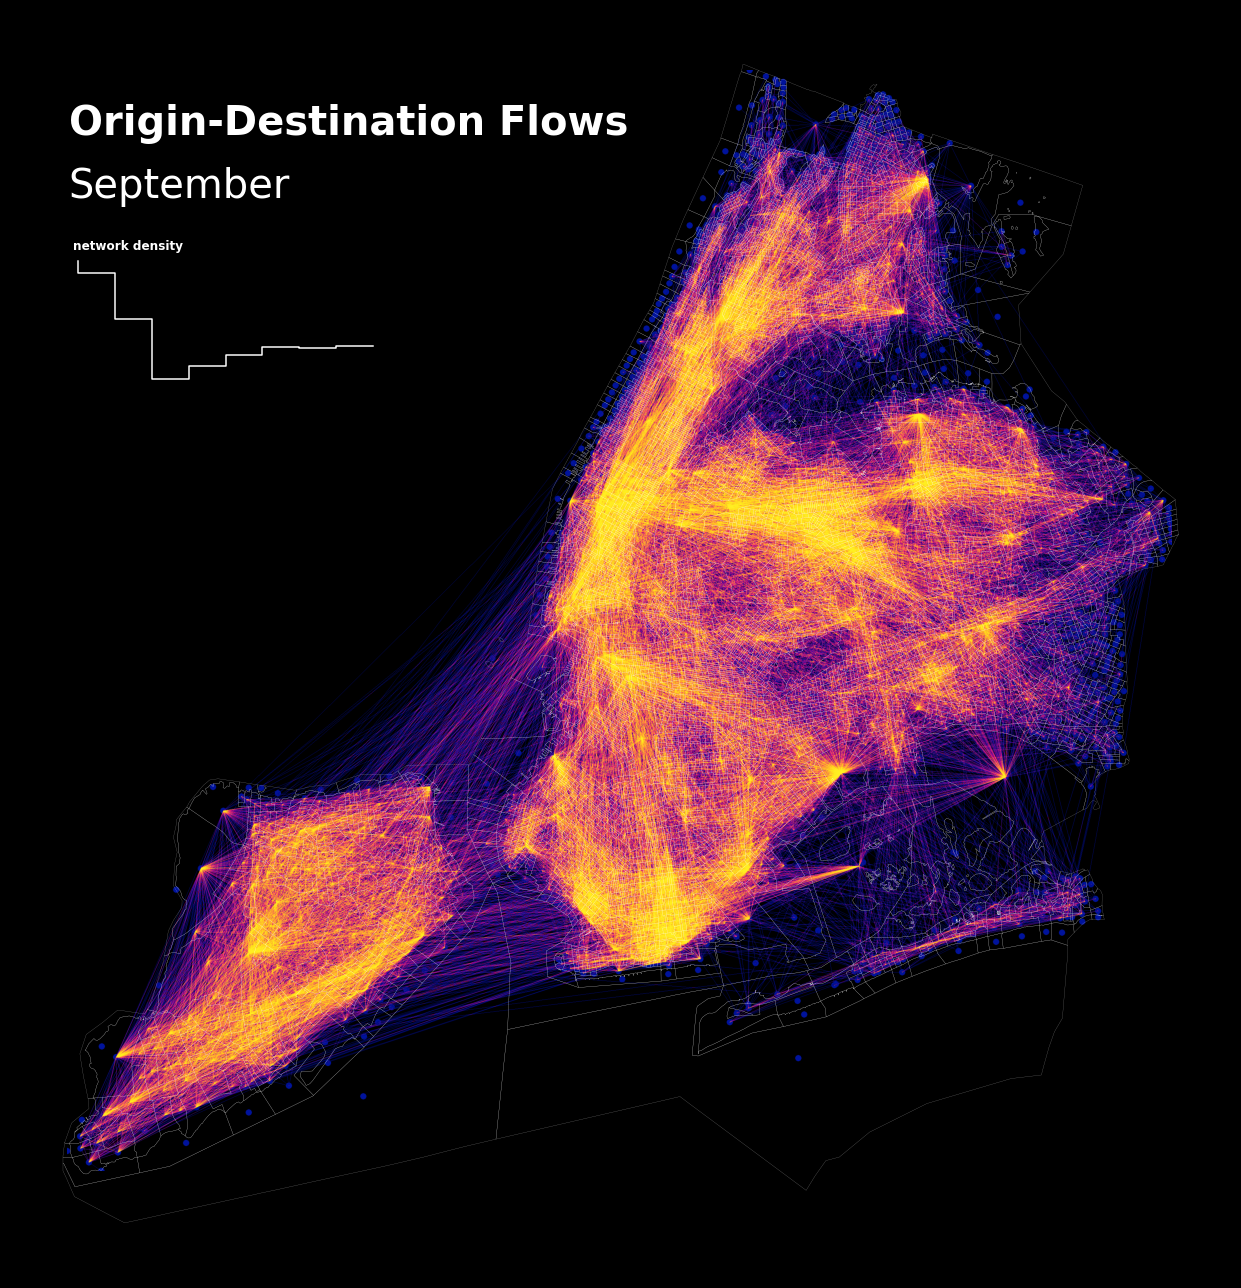

In [51]:
bnds = [(nodes['X'].min(), nodes['X'].max()), (nodes['Y'].min(), nodes['Y'].max())]

imgs = []
density = []

fig, ax = plt.subplots(figsize=(18, 18), facecolor='black')

for period in np.sort(edges.month.unique()):
    
    img = plot_graphs_by_month(fig, edges, nodes, period, x_range=bnds[0], y_range=bnds[1])
    imgs.append(img)

imageio.mimsave('nyc.gif', imgs, fps=1);

Now we can look at how the network hollows out in April and how it still has not recovered, months later, to January levels.